# Φόρτωση Δεδομένων

### Βημα 1

In [92]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torchtext

from PIL import Image
from pathlib import Path

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from utils import smooth
import numpy as np

In [81]:
# Φορτώστε τα δεδομένα από τα CSV αρχεία χρησιμοποιώντας το pandas
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

data = pd.concat([train_data, test_data])

classes = data.Classes.unique()

class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

In [82]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Assuming the first column contains file paths
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]  # Assuming the second column contains labels
        
        # Convert label to integer using class_to_idx dictionary
        label = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)

        return image, label

Στον παραπάνω κώδικα, η κλάση FoodDataset δέχεται ένα DataFrame ως είσοδο κατά την αρχικοποίηση και μπορεί να εφαρμόσει μετασχηματισμούς στις εικόνες αν το επιθυμείτε. Η μέθοδος __getitem__ επιστρέφει την εικόνα και την ετικέτα της για ένα συγκεκριμένο δείγμα.

In [83]:
# Διαίρεση σε σύνολα εκπαίδευσης και επικύρωσης
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Ορίστε τους μετασχηματισμούς που επιθυμείτε να εφαρμόσετε στις εικόνες
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Αλλάξτε το μέγεθος των εικόνων σε 224x224
    transforms.ToTensor(),  # Μετατρέψτε τις εικόνες σε tensors
    # Προσθέστε άλλους μετασχηματισμούς που χρειάζεστε
])

# Δημιουργία των FoodDataset instances
train_dataset = FoodDataset(train_set, transform=transform)
val_dataset = FoodDataset(val_set, transform=transform)

# Δημιουργία των PyTorch Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Αυτός ο κώδικας θα δημιουργήσει τα train_loader και val_loader που θα χρησιμοποιηθούν για την εκπαίδευση και την επικύρωση του μοντέλου σας αντίστοιχα. Είναι σημαντικό να εισάγετε τις απαραίτητες βιβλιοθήκες όπως το torch, torchvision, PIL, και pandas, και να προσαρμόσετε τα μονοπάτια για τα αρχεία CSV και τα μετασχηματισμούς στις ανάγκες του προγράμματός σας.

### Βημα 2

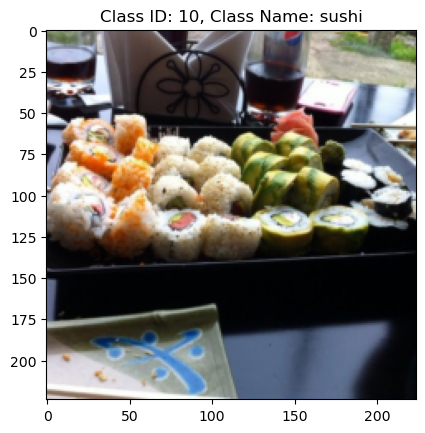

In [84]:
# Λειτουργία για να εμφανίζουμε τις εικόνες μαζί με το όνομα της κλάσης
def imshow_with_class(img, class_id, classes):
    class_name = list(classes.keys())[list(classes.values()).index(class_id)]
    plt.imshow(img.permute(1, 2, 0))  # Μετατροπή του tensor σε μορφή εικόνας (H, W, C)
    plt.title(f'Class ID: {class_id}, Class Name: {class_name}')
    plt.show()

# Λήψη ενός batch από τα δεδομένα εκπαίδευσης
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Εμφάνιση του πρώτου δείγματος από το batch
class_id = labels[0].item()
imshow_with_class(images[0], class_id, class_to_idx)

Αυτός ο κώδικας θα προβάλει την πρώτη εικόνα από το πρώτο batch, μαζί με την αντίστοιχη ετικέτα. Μπορείτε να το εκτελέσετε για να δείτε αν τα δεδομένα φορτώνονται σωστά και αν οι ετικέτες είναι σωστές.

### Βημα 3

Η συνάρτηση train_model θα πρέπει να εκπαιδεύει το μοντέλο για έναν συγκεκριμένο αριθμό εποχών, χρησιμοποιώντας έναν επιλεγμένο αλγόριθμο βελτιστοποίησης και ένα κριτήριο απώλειας. Κατά τη διάρκεια κάθε εποχής, θα πρέπει να υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης για να ελεγχθεί η απόδοση του μοντέλου. Στο τέλος κάθε εποχής, θα πρέπει να αποθηκεύονται οι μετρικές αυτές για μελλοντική αναφορά.

In [85]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    train_metrics = {'loss': [], 'accuracy': []}
    val_metrics = {'loss': [], 'accuracy': []}
    
    for epoch in range(num_epochs):
        # Εκπαίδευση
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_metrics['loss'].append(train_loss)
        train_metrics['accuracy'].append(train_accuracy)

        # Επικύρωση
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct / total
        val_metrics['loss'].append(val_loss)
        val_metrics['accuracy'].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    return train_metrics, val_metrics


Αυτή η συνάρτηση θα εκπαιδεύει το μοντέλο για τον αριθμό των εποχών που καθορίζετε. Κατά τη διάρκεια κάθε εποχής, υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης και αποθηκεύονται για μελλοντική αναφορά. Επιστρέφει τα ιστορικά των μετρικών για εκπαίδευση και επικύρωση.

Ας προχωρήσουμε τώρα στη συνάρτηση evaluate_model.

Η συνάρτηση evaluate_model θα χρησιμοποιηθεί για τον έλεγχο της απόδοσης του μοντέλου σε ένα σύνολο δεδομένων, είτε στο σύνολο επικύρωσης είτε στο σύνολο δοκιμής. Αυτή η συνάρτηση θα υπολογίζει την απώλεια και την ακρίβεια του μοντέλου.

In [86]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total

    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    return loss, accuracy


Αυτή η συνάρτηση αξιολογεί το μοντέλο στο δεδομένο data_loader, υπολογίζοντας την απώλεια και την ακρίβεια. Επιστρέφει επίσης την απώλεια και την ακρίβεια για μελλοντική αναφορά.

Αυτές οι συναρτήσεις μπορούν να χρησιμοποιηθούν για την εκπαίδευση και την αξιολόγηση ενός μοντέλου στο PyTorch.

### **1. Ποιος ο λόγος που έχουμε κρατήσει ένα κομμάτι του συνόλου εκπαίδευσης ως σύνολο επικύρωσης; ∆ε θα ήταν πιο λογικό να έχουμε περισσότερα δεδομένα για να εκπαιδεύσουμε τα μοντέλα μας; Εξηγήστε.**


Η κράτηση ενός κομματιού του συνόλου εκπαίδευσης ως σύνολο επικύρωσης έχει ως στόχο την αξιολόγηση της γενικευτικής ικανότητας του μοντέλου. Το σύνολο επικύρωσης χρησιμεύει για την επίβλεψη της απόδοσης του μοντέλου κατά τη διάρκεια της εκπαίδευσης και της προσαρμογής των υπερπαραμέτρων του μοντέλου (όπως ο ρυθμός μάθησης) ώστε να αποφευχθεί το overfitting. Η χρήση ενός ξεχωριστού συνόλου επικύρωσης βοηθά στην αποφυγή του overfitting και στη βελτίωση της γενίκευσης του μοντέλου. Αν εκπαιδεύαμε το μοντέλο με όλα τα δεδομένα, θα υπήρχε ο κίνδυνος να είναι πολύ καλό στο σύνολο εκπαίδευσης αλλά να μην γενικεύει καλά σε νέα δεδομένα.

### **2. Τί πρόβλημα καλούμαστε να λύσουμε στο συγκεκριμένο dataset; Ποια είναι η κατάλληλη συνάρτηση απώλειας για να εκπαιδεύσουμε ένα μοντέλο για ένα τέτοιου είδους προβλήματος;**

Το πρόβλημα που καλούμαστε να λύσουμε στο συγκεκριμένο dataset είναι η αναγνώριση της κατηγορίας των τροφίμων από εικόνες. Αυτό είναι ένα πρόβλημα ταξινόμησης πολλαπλών κατηγοριών, όπου κάθε εικόνα μπορεί να ανήκει σε μία από πολλές διαφορετικές κατηγορίες τροφίμων. Για την εκπαίδευση ενός μοντέλου για ένα τέτοιο πρόβλημα, μια κατάλληλη συνάρτηση απώλειας είναι η κατηγορική απώλεια (categorical cross-entropy), η οποία είναι κατάλληλη για την αναγνώριση πολλαπλών κατηγοριών.

# Εκπαίδευση Συνελικτικών ∆ικτύων

Αυτό το δίκτυο έχει τα επίπεδα που περιγράψατε, συμπεριλαμβανομένων τριών συνελικτικών επιπέδων, τριών επιπέδων συγκέντρωσης και ενός πλήρως συνδεδεμένου επιπέδου για την ταξινόμηση σε num_classes κλάσεις.

In [87]:
import torch
import torch.nn as nn

class SmallNet(nn.Module):
    def __init__(self, num_classes=11):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(128 * 28 * 28, num_classes)  # 28x28 after 3 max pooling layers
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        return x


Αρχικοποιήστε το παραπάνω μοντέλο ΣΝ∆ και εκπαιδεύστε υλοποιώντας τα παρακάτω

• Αλγόριθμο βελτιστοποίησης Adam με ρυθμό εκμάθησης 10−4

• Εκτύπωση της απώλειας (loss), ορθότητας (accuracy) των υποσυνόλων εκπαίδευσης και επικύρωσης

• 30 εποχές μέγιστη διάρκεια εκπαίδευσης

• Πρόωρο τερματισμό της εκπαίδευσης (Early Stopping) αν δεν παρουσιαστεί μείωση της απώλειας στο
σύνολο επικύρωσης για 5 συνεχείς εποχές

### Εκπαίδευση Συνελικτικών ∆ικτύων

In [95]:
# Initialize SmallNet
model = SmallNet(num_classes=11)  # Assuming 11 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training loop
num_epochs = 30
best_val_loss = float('inf')
patience = 5
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_loss /= len(train_loader)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
    
    if no_improvement == patience:
        print("Early stopping!")
        break

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.86it/s]


Epoch 1/30, Training Loss: 2.2625, Training Accuracy: 19.87%, Validation Loss: 2.1789, Validation Accuracy: 24.44%


Epoch 2/30: 100%|██████████| 124/124 [00:18<00:00,  6.67it/s]


Epoch 2/30, Training Loss: 2.0664, Training Accuracy: 29.18%, Validation Loss: 2.0636, Validation Accuracy: 29.04%


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.59it/s]


Epoch 3/30, Training Loss: 1.9365, Training Accuracy: 35.63%, Validation Loss: 2.0032, Validation Accuracy: 32.63%


Epoch 4/30: 100%|██████████| 124/124 [00:18<00:00,  6.70it/s]


Epoch 4/30, Training Loss: 1.8477, Training Accuracy: 39.20%, Validation Loss: 1.9657, Validation Accuracy: 33.89%


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.69it/s]


Epoch 5/30, Training Loss: 1.7544, Training Accuracy: 42.34%, Validation Loss: 1.9598, Validation Accuracy: 34.85%


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.69it/s]


Epoch 6/30, Training Loss: 1.6551, Training Accuracy: 46.15%, Validation Loss: 1.9376, Validation Accuracy: 34.65%


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.72it/s]


Epoch 7/30, Training Loss: 1.5304, Training Accuracy: 50.33%, Validation Loss: 1.9607, Validation Accuracy: 34.65%


Epoch 8/30: 100%|██████████| 124/124 [00:17<00:00,  6.95it/s]


Epoch 8/30, Training Loss: 1.4044, Training Accuracy: 55.40%, Validation Loss: 1.9501, Validation Accuracy: 36.06%


Epoch 9/30: 100%|██████████| 124/124 [00:18<00:00,  6.68it/s]


Epoch 9/30, Training Loss: 1.2802, Training Accuracy: 59.20%, Validation Loss: 1.9955, Validation Accuracy: 35.15%


Epoch 10/30: 100%|██████████| 124/124 [00:17<00:00,  6.98it/s]


Epoch 10/30, Training Loss: 1.1564, Training Accuracy: 63.40%, Validation Loss: 2.0527, Validation Accuracy: 36.31%


Epoch 11/30: 100%|██████████| 124/124 [00:18<00:00,  6.76it/s]


Epoch 11/30, Training Loss: 1.0227, Training Accuracy: 68.35%, Validation Loss: 2.1174, Validation Accuracy: 34.29%
Early stopping!


### Αξιολόγηση